In [2]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

In [3]:
# data exploration and preprocessing
# 1: analyse class distribution, visualise sample images， considering add the class name column and category column
# 3: examine provided features
train_metadata = pd.read_csv("/Users/xingzhidu/Desktop/ML/ML A2/dataset/train/train_metadata.csv")
# load feature files
hog_pca = pd.read_csv("/Users/xingzhidu/Desktop/ML/ML A2/dataset/train/Features/hog_pca.csv")
color_hist = pd.read_csv("/Users/xingzhidu/Desktop/ML/ML A2/dataset/train/Features/color_histogram.csv")
add_features = pd.read_csv("/Users/xingzhidu/Desktop/ML/ML A2/dataset/train/Features/additional_features.csv")

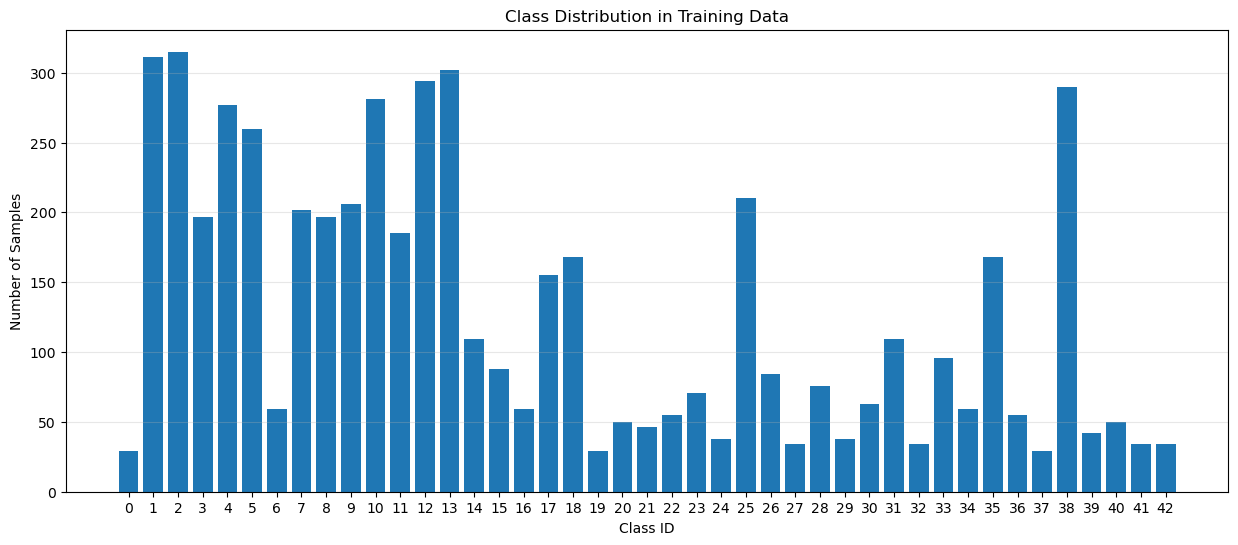

Number of classes: 43
Min (samples per class): 29 (Class 0)
Max (samples per class): 315 (Class 2)
Mean (samples per class): 127.63
Median (samples per class): 84.00

Potentially imbalanced classes (< 63.81 samples):
[0, 6, 16, 19, 20, 21, 22, 24, 27, 29, 30, 32, 34, 36, 37, 39, 40, 41, 42]


In [4]:
# analyze class distribution
class_distribution = train_metadata['ClassId'].value_counts().sort_index()

# plot class distribution
plt.figure(figsize=(15, 6))
plt.bar(class_distribution.index, class_distribution.values)
plt.xlabel('Class ID')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Data')
plt.xticks(range(43))
plt.grid(axis='y', alpha=0.3)
plt.savefig('class_distribution.png')
plt.show()

# print some statistics to see the class distribution
print(f"Number of classes: {len(class_distribution)}")
print(f"Min (samples per class): {min(class_distribution.values)} (Class {class_distribution.values.argmin()})")
print(f"Max (samples per class): {max(class_distribution.values)} (Class {class_distribution.values.argmax()})")
print(f"Mean (samples per class): {np.mean(class_distribution.values):.2f}")
print(f"Median (samples per class): {np.median(class_distribution.values):.2f}")

# identify potential imbalanced classes
# define a threshold as half the average number of samples per class
imbalanced_threshold = np.mean(class_distribution.values) / 2
imbalanced_classes = class_distribution[class_distribution < imbalanced_threshold]
print(f"\nPotentially imbalanced classes (< {imbalanced_threshold:.2f} samples):")
print(imbalanced_classes.index.tolist())

In [5]:
# When identifying imbalanced classes, our goal is to find classes that have significantly fewer samples compared to others 
# because normally ML models tend to perform poorly on such underrepresented classes, we will see how model performance on these classes later
# we find there is significant imbalance across the 43 classess, 
# so we will consider data augmentation for underrepresented classes.

In [6]:
# create a dictionary mapping ClassId to sign name 
# based on the GTSRB dataset documentation
sign_names = {
    0: 'Speed limit (20km/h)',
    1: 'Speed limit (30km/h)',
    2: 'Speed limit (50km/h)',
    3: 'Speed limit (60km/h)',
    4: 'Speed limit (70km/h)',
    5: 'Speed limit (80km/h)',
    6: 'End of speed limit (80km/h)',
    7: 'Speed limit (100km/h)',
    8: 'Speed limit (120km/h)',
    9: 'No passing',
    10: 'No passing for vehicles over 3.5 metric tons',
    11: 'Right-of-way at the next intersection',
    12: 'Priority road',
    13: 'Yield',
    14: 'Stop',
    15: 'No vehicles',
    16: 'Vehicles over 3.5 metric tons prohibited',
    17: 'No entry',
    18: 'General caution',
    19: 'Dangerous curve to the left',
    20: 'Dangerous curve to the right',
    21: 'Double curve',
    22: 'Bumpy road',
    23: 'Slippery road',
    24: 'Road narrows on the right',
    25: 'Road work',
    26: 'Traffic signals',
    27: 'Pedestrians',
    28: 'Children crossing',
    29: 'Bicycles crossing',
    30: 'Beware of ice/snow',
    31: 'Wild animals crossing',
    32: 'End of all speed and passing limits',
    33: 'Turn right ahead',
    34: 'Turn left ahead',
    35: 'Ahead only',
    36: 'Go straight or right',
    37: 'Go straight or left',
    38: 'Keep right',
    39: 'Keep left',
    40: 'Roundabout mandatory',
    41: 'End of no passing',
    42: 'End of no passing by vehicles over 3.5 metric tons'
}

# add sign names to the training metadata
train_metadata['SignName'] = train_metadata['ClassId'].map(sign_names)

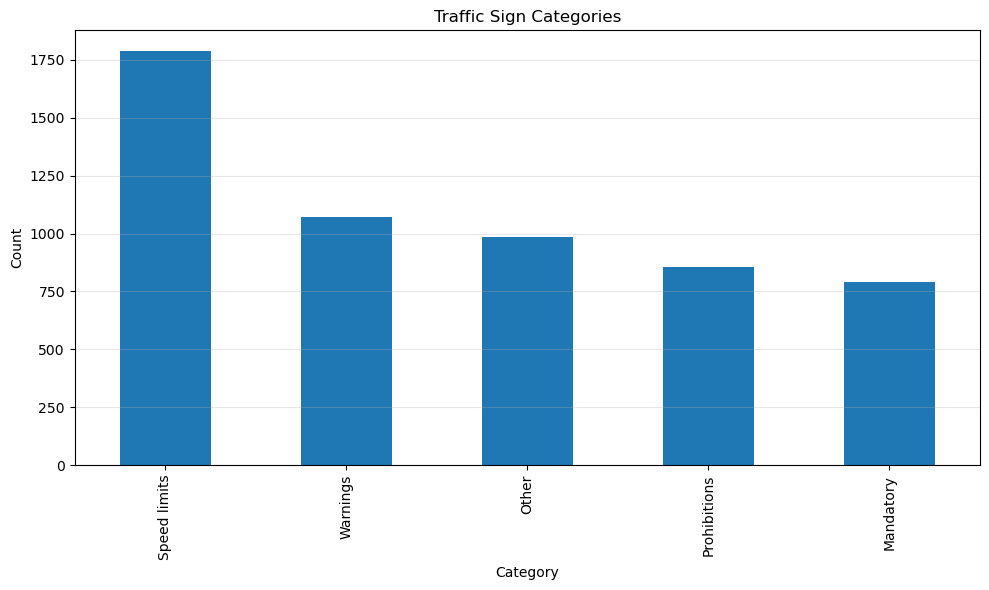

In [9]:
# group signs into categories for analysis
sign_categories = {
    'Speed limits': [0, 1, 2, 3, 4, 5, 7, 8],
    'Prohibitions': [9, 10, 15, 16, 17, 41, 42],
    'Warnings': [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
    'Mandatory': [33, 34, 35, 36, 37, 38, 39, 40],
    'Other': [6, 11, 12, 13, 14, 32]
}

# add categories to metadata
def assign_category(class_id):
    for category, class_ids in sign_categories.items():
        if class_id in class_ids:
            return category
    return 'Unknown'

train_metadata['Category'] = train_metadata['ClassId'].apply(assign_category)

# display category distribution
category_distribution = train_metadata['Category'].value_counts()
plt.figure(figsize=(10, 6))
category_distribution.plot(kind='bar')
plt.title('Traffic Sign Categories')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('category_distribution.png')
plt.show()

In [14]:
# from the category distribution image, we find speed limit signs make up largest category

In [16]:
train_metadata.head()

,id,image_path,ClassId,SignName,Category
0,7218,img_000001.jpg,32,End of all speed and passing limits,Other
1,6333,img_000002.jpg,13,Yield,Other
2,6867,img_000003.jpg,7,Speed limit (100km/h),Speed limits
3,7730,img_000004.jpg,4,Speed limit (70km/h),Speed limits
4,6338,img_000005.jpg,35,Ahead only,Mandatory


In [18]:
train_metadata.to_csv("/Users/xingzhidu/Desktop/ML/ML A2/dataset/train/train_metadata.csv", index=False)

In [20]:
# function to visualize sample images from each class, show 5 sample images for each class
def visualize_class_samples(class_id, num_samples=5):
    class_images = train_metadata[train_metadata['ClassId'] == class_id]['image_path'].values[:num_samples]
    sign_name = sign_names[class_id]
    
    fig, axes = plt.subplots(1, len(class_images), figsize=(15, 3))
    fig.suptitle(f'Class {class_id}: {sign_name}', fontsize=16)
    
    for i, img_path in enumerate(class_images):
        full_path = os.path.join("/Users/xingzhidu/Desktop/ML/ML A2/dataset/train", img_path)
        img = cv2.imread(full_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if len(class_images) > 1:
            axes[i].imshow(img)
            axes[i].axis('off')
        else:
            axes.imshow(img)
            axes.axis('off')
    
    plt.tight_layout()
    #plt.savefig(f'class_{class_id}_samples.png')
    plt.show()

# for brevity, we only look at a subset of classes in each category
#for category, class_ids in sign_categories.items():
    #print(f"\n{category} Signs:")
    # Select up to 3 classes from each category
    #for class_id in class_ids[:3]:
        #visualize_class_samples(class_id)

# to have a look about traffic sign images samples

In [22]:
from collections import Counter

Processing 5488 images in 11 batches...

Image properties analysis based on 5488 images:
Height - Min: 25, Max: 191, Mean: 50.06
Width - Min: 25, Max: 208, Mean: 50.57
Aspect Ratio - Min: 0.46, Max: 1.35, Mean: 1.01
File Size (KB) - Min: 1.01, Max: 79.09, Mean: 5.75
Channels - Most common: 3


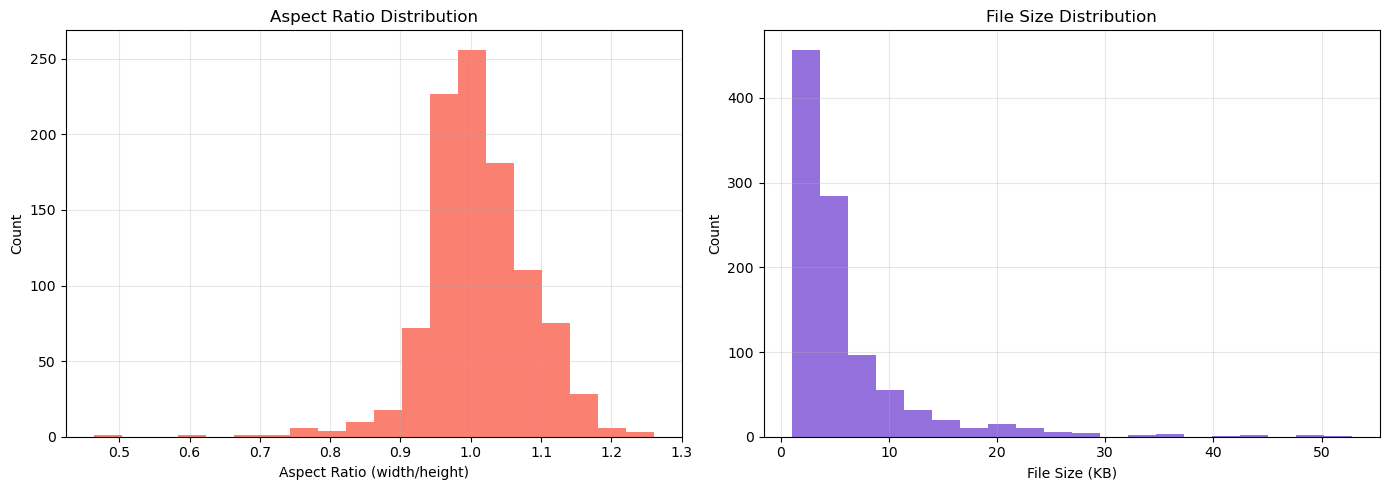

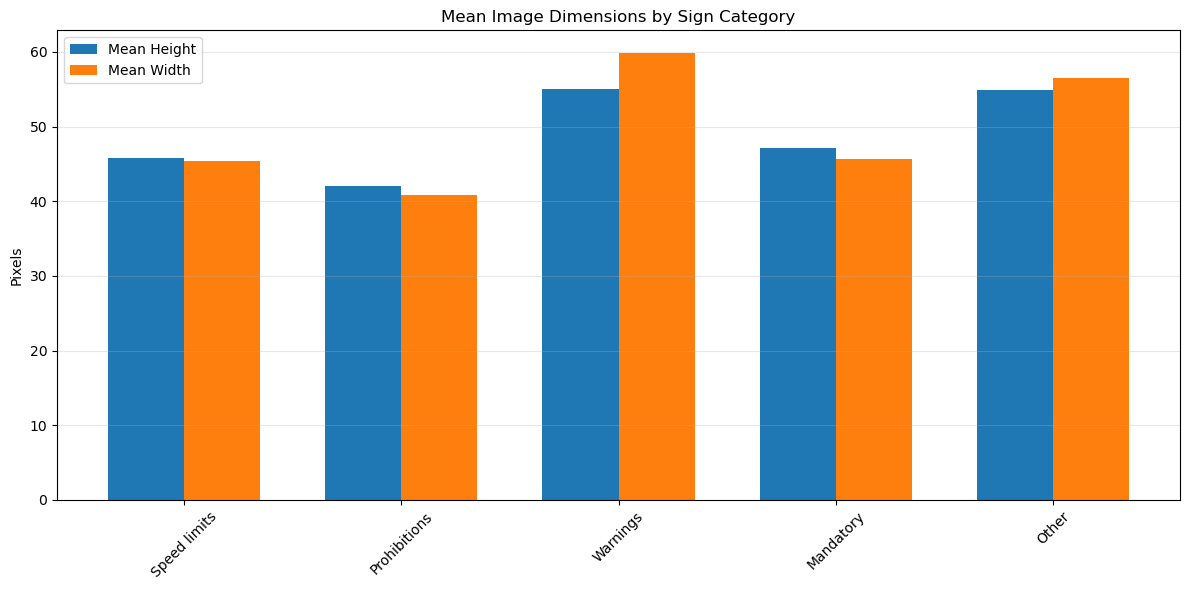

In [24]:
# function to analyze image properties like size  and aspect ratio
def analyze_image_properties(max_samples=None):
    """
    Parameters:
    max_samples (int, optional): represnts the maximum number of samples to analyze. If None, means to analyze all images.
    """
    # get all image paths
    image_paths = train_metadata['image_path'].values
    
    # use all images if max_samples is None, otherwise use the specified number
    if max_samples is not None and max_samples < len(image_paths):
        sampled_paths = np.random.choice(image_paths, max_samples, replace=False)
    else:
        sampled_paths = image_paths
        
    # initialize storage for properties
    heights = []
    widths = []
    channels = []
    aspect_ratios = []
    file_sizes = []
    
    # process images in batches to avoid memory issues
    batch_size = 500
    num_batches = (len(sampled_paths) + batch_size - 1) // batch_size

    print(f"Processing {len(sampled_paths)} images in {num_batches} batches...")
    
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(sampled_paths))
        batch_paths = sampled_paths[start_idx:end_idx]
        
        for img_path in batch_paths:
            full_path = os.path.join("/Users/xingzhidu/Desktop/ML/ML A2/dataset/train", img_path)
            if os.path.exists(full_path):
                # get file size
                file_sizes.append(os.path.getsize(full_path) / 1024)  # size in KB
                
                # read image
                img = cv2.imread(full_path)
                if img is not None:
                    heights.append(img.shape[0])
                    widths.append(img.shape[1])
                    channels.append(img.shape[2])
                    aspect_ratios.append(img.shape[1] / img.shape[0])
                    
    # print statistics based on the full dataset
    print(f"\nImage properties analysis based on {len(heights)} images:")
    print(f"Height - Min: {min(heights)}, Max: {max(heights)}, Mean: {np.mean(heights):.2f}")
    print(f"Width - Min: {min(widths)}, Max: {max(widths)}, Mean: {np.mean(widths):.2f}")
    print(f"Aspect Ratio - Min: {min(aspect_ratios):.2f}, Max: {max(aspect_ratios):.2f}, Mean: {np.mean(aspect_ratios):.2f}")
    print(f"File Size (KB) - Min: {min(file_sizes):.2f}, Max: {max(file_sizes):.2f}, Mean: {np.mean(file_sizes):.2f}")
    print(f"Channels - Most common: {Counter(channels).most_common(1)[0][0]}")
    
    # create smaller histograms for visualization efficiency
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # for visualization, we can use a sample if there are too many points
    plot_sample_size = min(len(heights), 1000)
    plot_indices = np.random.choice(len(heights), plot_sample_size, replace=False) if len(heights) > plot_sample_size else np.arange(len(heights))
    
    # plot histograms using the sample  
    axes[0].hist([aspect_ratios[i] for i in plot_indices], bins=20, color='salmon')
    axes[0].set_title('Aspect Ratio Distribution')
    axes[0].set_xlabel('Aspect Ratio (width/height)')
    axes[0].set_ylabel('Count')
    axes[0].grid(alpha=0.3)
    
    axes[1].hist([file_sizes[i] for i in plot_indices], bins=20, color='mediumpurple')
    axes[1].set_title('File Size Distribution')
    axes[1].set_xlabel('File Size (KB)')
    axes[1].set_ylabel('Count')
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('image_properties.png')
    plt.show()
 
    # check if there's significant variation by category
    category_heights = {category: [] for category in sign_categories.keys()}
    category_widths = {category: [] for category in sign_categories.keys()}
    
    for _, row in train_metadata.sample(n=min(500, len(train_metadata))).iterrows():
        full_path = os.path.join("/Users/xingzhidu/Desktop/ML/ML A2/dataset/train", row['image_path'])
        if os.path.exists(full_path):
            img = cv2.imread(full_path)
            if img is not None:
                category_heights[row['Category']].append(img.shape[0])
                category_widths[row['Category']].append(img.shape[1])
    
    # plot mean dimensions by category
    categories = []
    mean_heights = []
    mean_widths = []
    
    for category, heights in category_heights.items():
        if heights:  # Ensure we have data
            categories.append(category)
            mean_heights.append(np.mean(heights))
            mean_widths.append(np.mean(category_widths[category]))
    
    x = np.arange(len(categories))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, mean_heights, width, label='Mean Height')
    rects2 = ax.bar(x + width/2, mean_widths, width, label='Mean Width')
    
    ax.set_ylabel('Pixels')
    ax.set_title('Mean Image Dimensions by Sign Category')
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=45)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('dimensions_by_category.png')
    plt.show()

analyze_image_properties()

In [25]:
# we find most images are relatively small , with heights and widths typically between 45-60 pixels
# most traffic signs have an aspect ratio very close to 1
# warning signs tend to be larger around 55✖️60 compared to other signs
# (especially speed limits and prohibitions signs)

In [26]:
# basic analysis of provided features


Color Histogram Features:
Number of features: 96
Total missing values: 0

Feature statistics (first 5 features):
          mean       std  min       max
ch_0  0.001594  0.017190  0.0  0.630910
ch_1  0.091166  0.222423  0.0  0.993316
ch_2  0.233191  0.300232  0.0  0.993788
ch_3  0.261800  0.257555  0.0  0.995194
ch_4  0.248081  0.222946  0.0  0.983005


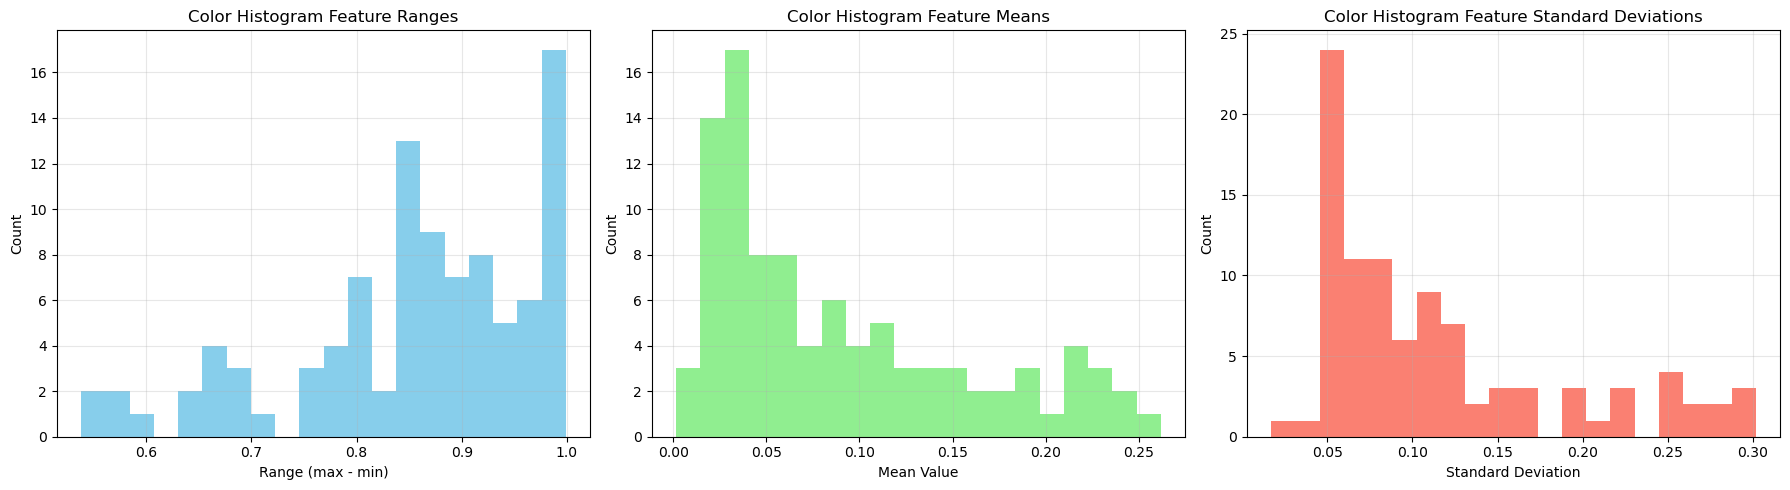


HOG PCA Features:
Number of features: 20
Total missing values: 0

Feature statistics (first 5 features):
                   mean       std       min       max
hog_pca_0 -3.923591e-07  1.792857 -3.002755  3.717479
hog_pca_1 -1.945055e-07  1.102799 -2.035571  3.969204
hog_pca_2 -4.774052e-10  0.941575 -2.898584  2.211293
hog_pca_3 -1.054389e-07  0.735296 -2.611643  1.596566
hog_pca_4  1.137846e-08  0.660458 -2.547139  2.784895


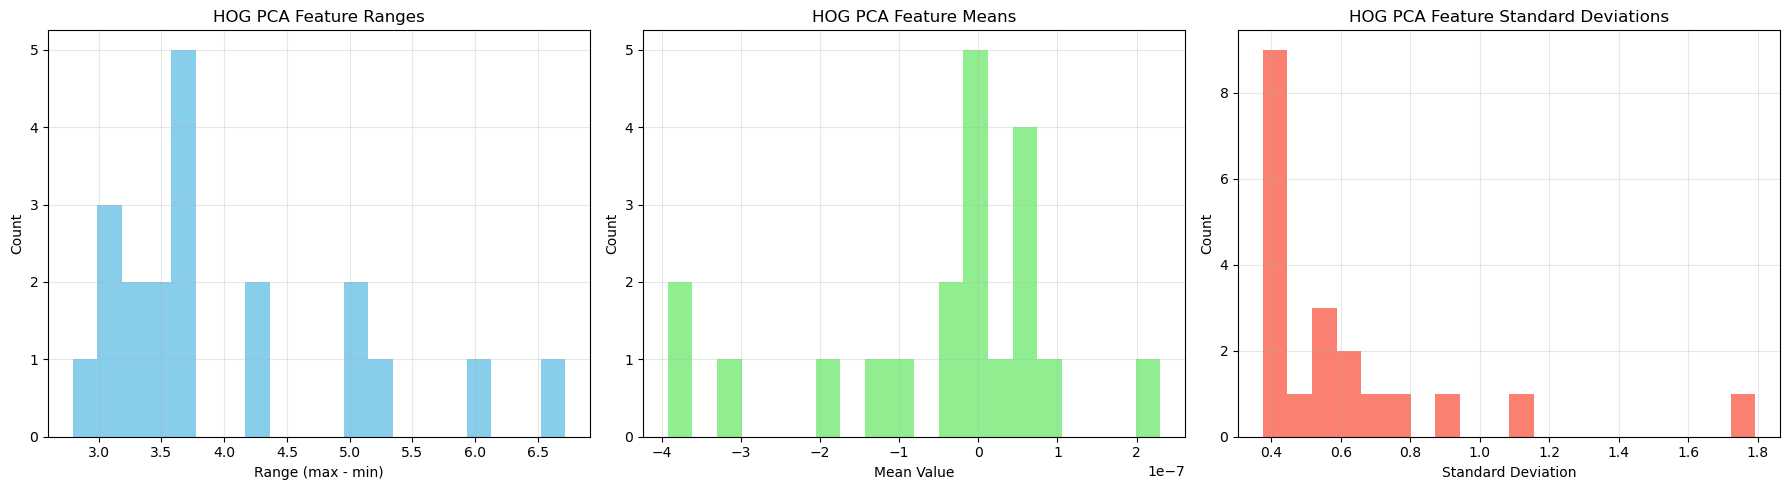


Additional Features:
Number of features: 4
Total missing values: 0

Feature statistics (first 5 features):
                   mean        std       min         max
edge_density   0.091678   0.072312  0.000000    0.317383
mean_r        87.452502  51.082152  8.326660  251.132568
mean_g        80.003171  47.214124  7.042725  244.010010
mean_b        82.192781  47.171930  9.413818  250.570068


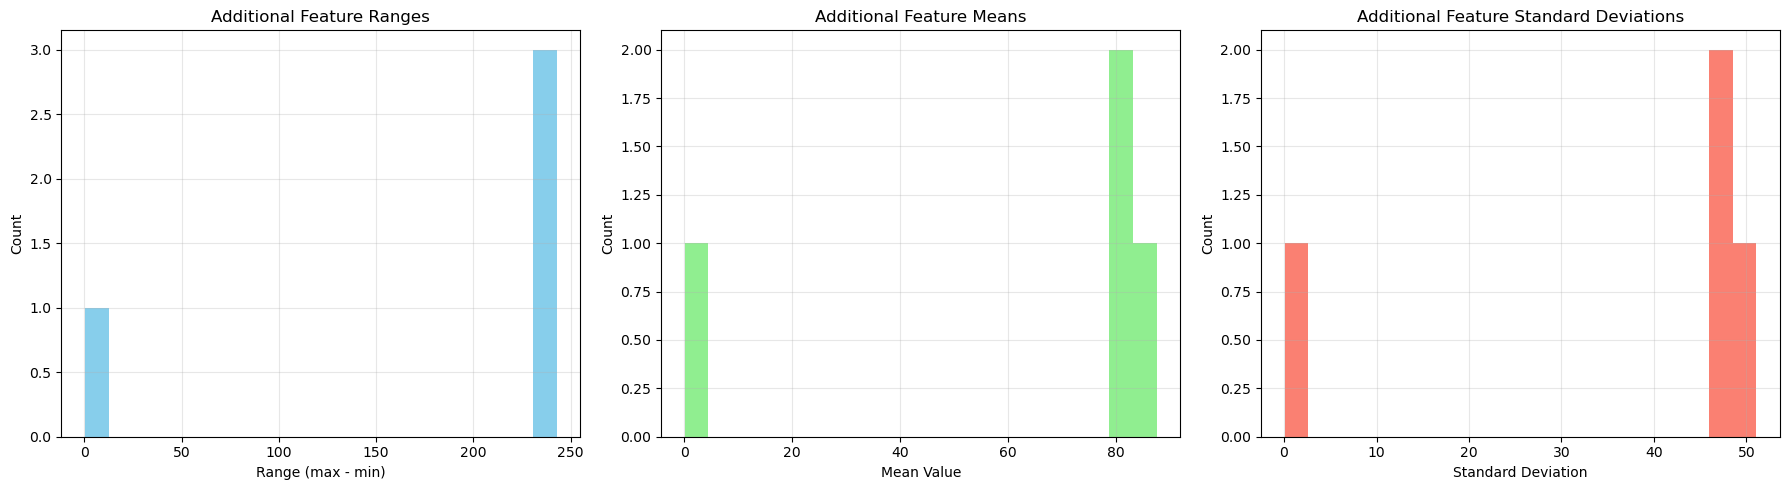

In [27]:
# define feature column groups
color_hist_cols = [col for col in color_hist.columns if col.startswith('ch_')]
hog_pca_cols = [col for col in hog_pca.columns if col.startswith('hog_pca_')]
add_feature_cols = ['edge_density', 'mean_r', 'mean_g', 'mean_b']

# function to examine basic properties of feature sets
def examine_feature_set(df, feature_cols, name):
    print(f"\n{name} Features:")
    print(f"Number of features: {len(feature_cols)}")
    
    # Check for missing values
    missing = df[feature_cols].isnull().sum().sum()
    print(f"Total missing values: {missing}")
    
    # basic statistics
    stats = df[feature_cols].describe().T[['mean', 'std', 'min', 'max']]
    print("\nFeature statistics (first 5 features):")
    print(stats.head())
    
    # value ranges and distributions
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 1. feature ranges
    ranges = stats['max'] - stats['min']
    axes[0].hist(ranges, bins=20, color='skyblue')
    axes[0].set_title(f'{name} Feature Ranges')
    axes[0].set_xlabel('Range (max - min)')
    axes[0].set_ylabel('Count')
    axes[0].grid(alpha=0.3)
    
    # 2. feature means
    axes[1].hist(stats['mean'], bins=20, color='lightgreen')
    axes[1].set_title(f'{name} Feature Means')
    axes[1].set_xlabel('Mean Value')
    axes[1].set_ylabel('Count')
    axes[1].grid(alpha=0.3)
    
    # 3. feature standard deviations
    axes[2].hist(stats['std'], bins=20, color='salmon')
    axes[2].set_title(f'{name} Feature Standard Deviations')
    axes[2].set_xlabel('Standard Deviation')
    axes[2].set_ylabel('Count')
    axes[2].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{name.lower().replace(" ", "_")}_feature_properties.png')
    plt.show()
    
    # sample a few features for distribution visualization
    #n_samples = min(5, len(feature_cols))
    #sample_features = np.random.choice(feature_cols, n_samples, replace=False)
    
    #plt.figure(figsize=(15, 3*n_samples))
    #for i, feature in enumerate(sample_features):
        #plt.subplot(n_samples, 1, i+1)
        #sns.histplot(df[feature], kde=True, color='mediumseagreen')
        #plt.title(f'Distribution of {feature}')
        #plt.grid(alpha=0.3)
    
    #plt.tight_layout()
    #plt.savefig(f'{name.lower().replace(" ", "_")}_distributions.png')
    #plt.show()

# examine each feature set
examine_feature_set(color_hist, color_hist_cols, "Color Histogram")
examine_feature_set(hog_pca, hog_pca_cols, "HOG PCA")
examine_feature_set(add_features, add_feature_cols, "Additional")

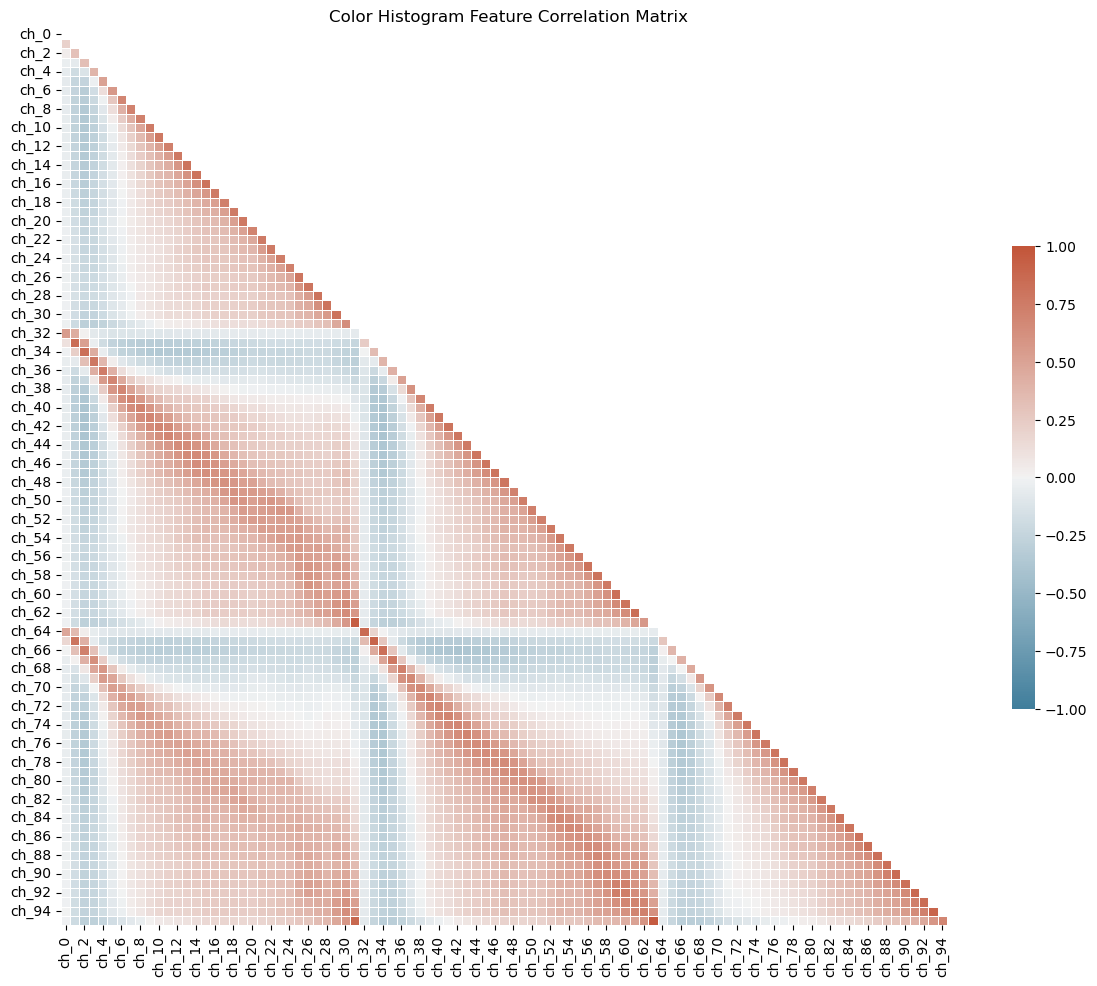


Color Histogram Feature Correlation Summary:
Mean absolute correlation: 0.2538
Median absolute correlation: 0.2345
Max correlation: 0.9600
Min correlation: -0.4024
Highly correlated feature pairs (|corr| > 0.8): 28 (0.61%)


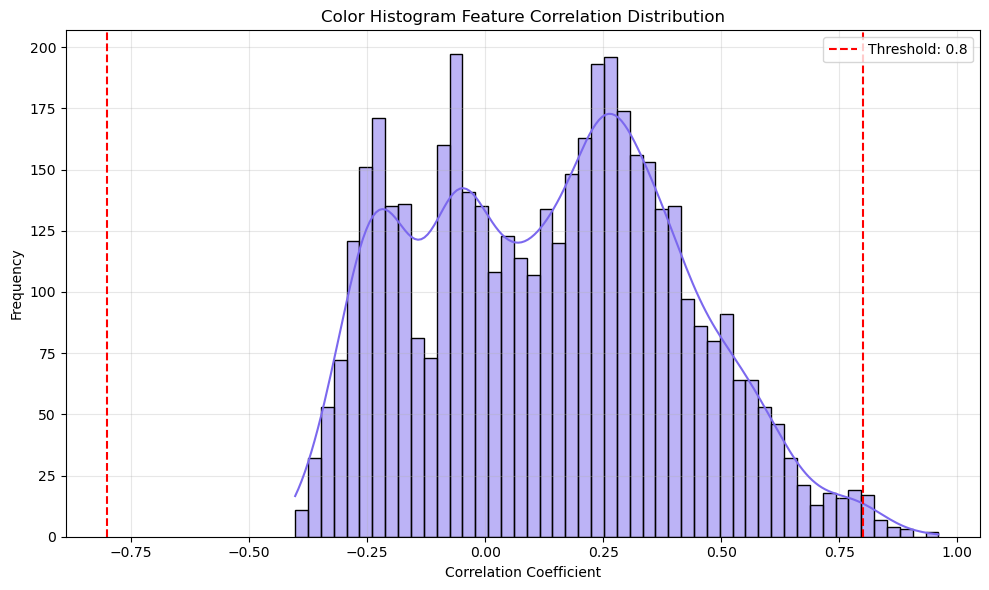

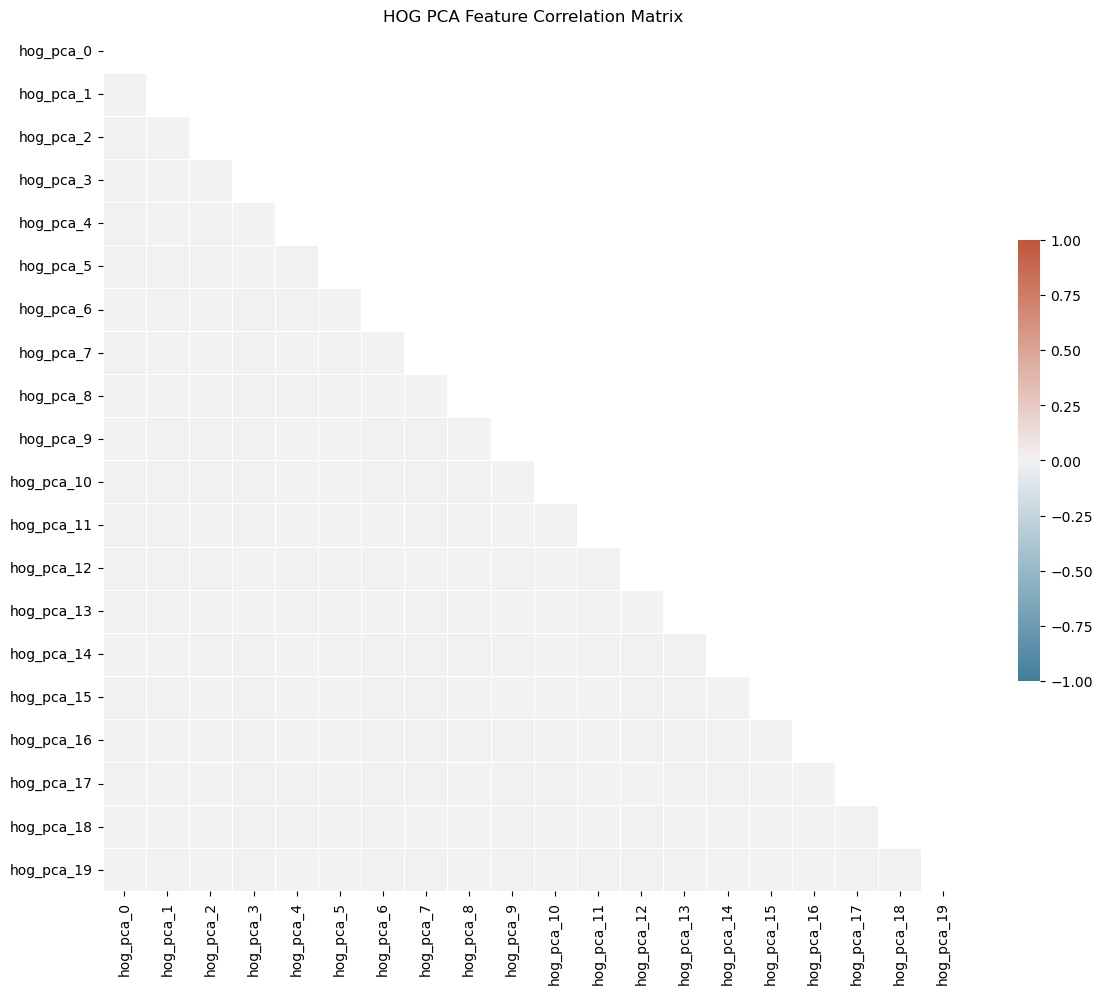


HOG PCA Feature Correlation Summary:
Mean absolute correlation: 0.0000
Median absolute correlation: 0.0000
Max correlation: 0.0000
Min correlation: -0.0000
Highly correlated feature pairs (|corr| > 0.8): 0 (0.00%)


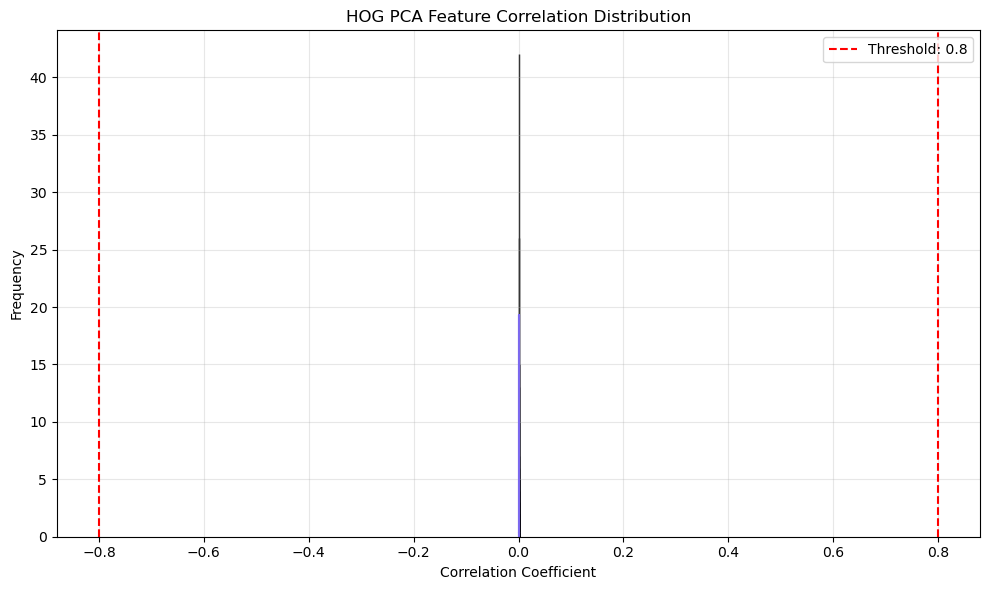

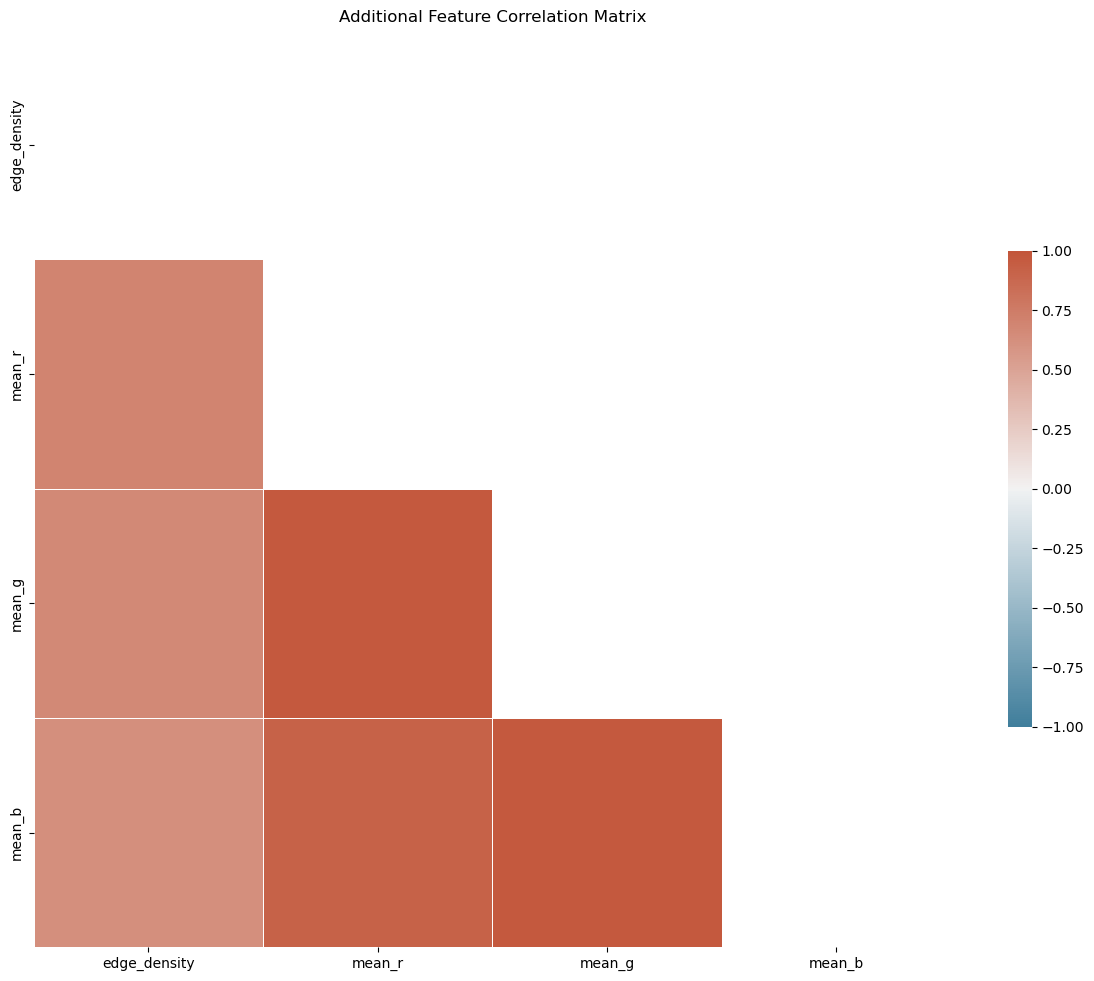


Additional Feature Correlation Summary:
Mean absolute correlation: 0.8116
Median absolute correlation: 0.8118
Max correlation: 0.9763
Min correlation: 0.6262
Highly correlated feature pairs (|corr| > 0.8): 3 (50.00%)


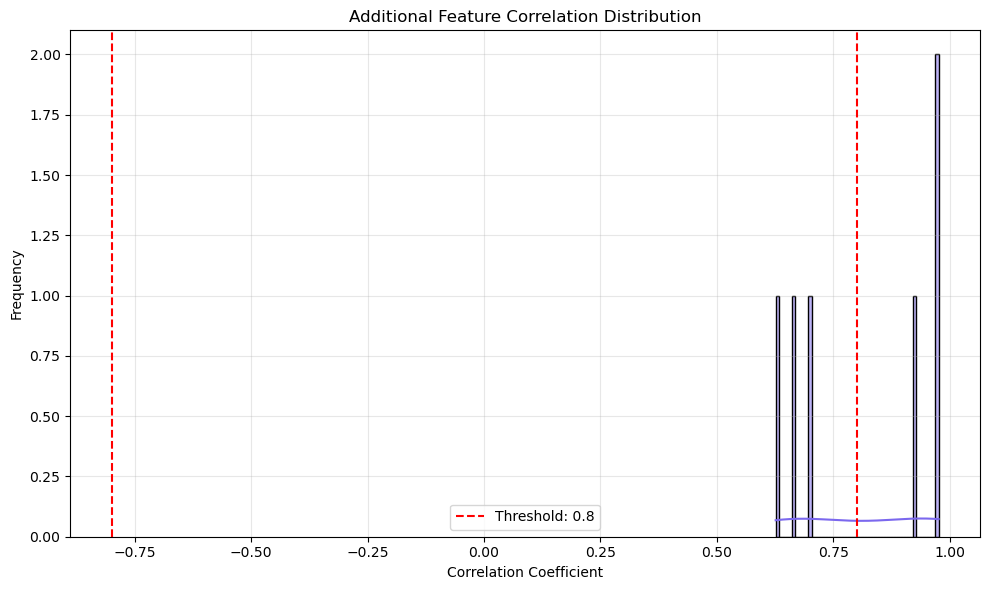

In [32]:
# function to analyze correlations within feature sets
def analyze_feature_correlations(df, feature_cols, name):
    # calculate correlation matrix
    corr = df[feature_cols].corr()
    
    # visualize correlation matrix
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
    plt.title(f'{name} Feature Correlation Matrix')
    plt.tight_layout()
    plt.savefig(f'{name.lower().replace(" ", "_")}_correlation.png')
    plt.show()
    
    # calculate correlation summary statistics
    corr_values = corr.values[np.triu_indices_from(corr.values, k=1)]
    
    print(f"\n{name} Feature Correlation Summary:")
    print(f"Mean absolute correlation: {np.mean(np.abs(corr_values)):.4f}")
    print(f"Median absolute correlation: {np.median(np.abs(corr_values)):.4f}")
    print(f"Max correlation: {np.max(corr_values):.4f}")
    print(f"Min correlation: {np.min(corr_values):.4f}")
    
    # count highly correlated features
    high_corr_threshold = 0.8
    high_corr_count = np.sum(np.abs(corr_values) > high_corr_threshold)
    total_pairs = len(corr_values)
    
    print(f"Highly correlated feature pairs (|corr| > {high_corr_threshold}): {high_corr_count} ({high_corr_count/total_pairs*100:.2f}%)")
    
    # plot correlation distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(corr_values, bins=50, kde=True, color='mediumslateblue')
    plt.axvline(x=high_corr_threshold, color='red', linestyle='--', label=f'Threshold: {high_corr_threshold}')
    plt.axvline(x=-high_corr_threshold, color='red', linestyle='--')
    plt.title(f'{name} Feature Correlation Distribution')
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('Frequency')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'{name.lower().replace(" ", "_")}_correlation_dist.png')
    plt.show()

# analyze correlations for each feature set
analyze_feature_correlations(color_hist, color_hist_cols, "Color Histogram")
analyze_feature_correlations(hog_pca, hog_pca_cols, "HOG PCA") 
analyze_feature_correlations(add_features, add_feature_cols, "Additional")

In [33]:
def check_for_anomalies():
    # combine all feature dataframes
    features_df = color_hist.copy()
    features_df = features_df.merge(hog_pca, on='image_path')
    features_df = features_df.merge(add_features, on='image_path')
    
    # get all numeric columns
    numeric_cols = features_df.select_dtypes(include=[np.number]).columns.tolist()
    
    # check for infinite values
    inf_count = np.isinf(features_df[numeric_cols]).sum().sum()
    print(f"\nInfinite values in features: {inf_count}")
    
    # check for zeros and constant values more efficiently
    zero_cols = []
    constant_cols = []
    
    for col in numeric_cols:
        # check first if minimum equals maximum (constant)
        min_val = features_df[col].min()
        max_val = features_df[col].max()
        
        if min_val == max_val:
            if min_val == 0:
                zero_cols.append(col)
            else:
                constant_cols.append(col)
    if zero_cols:
        print(f"\nColumns with all zeros: {len(zero_cols)}")
        print(zero_cols)
    
    if constant_cols:
        print(f"\nColumns with constant values: {len(constant_cols)}")
        print(constant_cols)
    
    # check for extreme outliers using IQR - optimize by processing in batches
    outlier_features = []
    
    # process 20 features at a time
    batch_size = 20
    for i in range(0, len(numeric_cols), batch_size):
        batch_cols = numeric_cols[i:i+batch_size]
        
        for col in batch_cols:
            Q1 = features_df[col].quantile(0.25)
            Q3 = features_df[col].quantile(0.75)
            IQR = Q3 - Q1
            
            extreme_lower = Q1 - 3 * IQR
            extreme_upper = Q3 + 3 * IQR
            
            outlier_count = ((features_df[col] < extreme_lower) | (features_df[col] > extreme_upper)).sum()

            if outlier_count > 0:
                outlier_percent = outlier_count / len(features_df) * 100
                if outlier_percent > 1:  # Only report if more than 1% are outliers
                    outlier_features.append((col, outlier_count, outlier_percent))
    
    if outlier_features:
        print("\nFeatures with extreme outliers (>1% of data):")
        for feature, count, percent in sorted(outlier_features, key=lambda x: x[2], reverse=True)[:10]:
            print(f"{feature}: {count} outliers ({percent:.2f}%)")

check_for_anomalies()


Infinite values in features: 0

Features with extreme outliers (>1% of data):
ch_33: 1038 outliers (18.91%)
ch_65: 1007 outliers (18.35%)
ch_1: 926 outliers (16.87%)
ch_0: 750 outliers (13.67%)
ch_64: 714 outliers (13.01%)
ch_63: 548 outliers (9.99%)
ch_31: 406 outliers (7.40%)
ch_32: 267 outliers (4.87%)
ch_62: 266 outliers (4.85%)
ch_95: 266 outliers (4.85%)


In [36]:
# analysis of provided color histogram :
# images above show moderate correlation and significant skewness with many outliers. 
# The block patterns in the correlation matrix suggest that neighboring bins 
# in the color histogram are correlated, which is expected as similar colors 
# often appear together in traffic signs

# analysis of provided Hog_PCA features:
# The Hog_PCA correlation matrix shows very low correlation between features, appearing almost white. 
# This suggests PCA has successfully created orthogonal features.

# most hog_PCA features follow approximately normal distributions centered around zero
# which is ideal for many machine learning algorithms.


# analysis of provided additional features:
# extremely high correlations(mean absolute correlation of 0.8116)
# wide and different ranges(color channels span about 240 units while edge_density spans about 0.32 units.


# there are no infinite values in features 
# Ten color histogram features contain significant outliers (>1% of data), with some affecting nearly 19% of samples. 
# These outliers likely represent rare color patterns in specific sign types.

In [ ]:
# this notebook is a deatiled exploration of training dataset for later feature engineering and model implementation and evaluations